In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
df = pd.read_csv("Income.csv")
for col in ['avg_salary', 'min_salary', 'max_salary']:
    df[col] = df[col].str.replace('L', '').astype(float)
numerical_cols = ['min_experience', 'avg_salary', 'min_salary', 'max_salary']
def remove_outliers_iqr(data, cols):
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower) & (data[col] <= upper)]
    return data
df_clean = remove_outliers_iqr(df, numerical_cols)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean[numerical_cols])
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
point1 = np.array([1, inertia[0]])
point2 = np.array([10, inertia[-1]])
distances = []
for i in range(len(K_range)):
    point = np.array([K_range[i], inertia[i]])
    distance = np.abs(np.cross(point2 - point1, point1 - point)) / np.linalg.norm(point2 - point1)
    distances.append(distance)
optimal_k = distances.index(max(distances)) + 1
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(scaled_data)
df_clean['cluster'] = labels
silhouette = silhouette_score(scaled_data, labels)
db_index = davies_bouldin_score(scaled_data, labels)
ch_score = calinski_harabasz_score(scaled_data, labels)
print(f"Optimal k = {optimal_k}")
print(f"Silhouette Score = {silhouette:.4f}")
print(f"Davies-Bouldin Index = {db_index:.4f}")
print(f"Calinski-Harabasz Score = {ch_score:.2f}")

Optimal k = 3
Silhouette Score = 0.3580
Davies-Bouldin Index = 0.9709
Calinski-Harabasz Score = 1541.67


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=scaled_data[:, 0],  # min_experience
    y=scaled_data[:, 1],  # avg_salary
    hue=df_clean['cluster'],
    palette='Set1',
    s=60
)
plt.title('KMeans Clusters (2D View)')
plt.xlabel('Standardized Min Experience')
plt.ylabel('Standardized Avg Salary')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()
cluster_summary = df_clean.groupby('cluster')[numerical_cols].mean().round(2)
print("Cluster Summary Statistics (mean values):")
print(cluster_summary)

Cluster Summary Statistics (mean values):
         min_experience  avg_salary  min_salary  max_salary
cluster                                                    
0                  1.18        6.07        3.84        9.61
1                  4.49       19.83       13.82       26.51
2                  2.49       12.43        7.49       18.78


C:\Users\YASHRAJ\AppData\Local\Temp\ipykernel_9652\1799497650.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='cluster', y=col, palette='Set2')
C:\Users\YASHRAJ\AppData\Local\Temp\ipykernel_9652\1799497650.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='cluster', y=col, palette='Set2')
C:\Users\YASHRAJ\AppData\Local\Temp\ipykernel_9652\1799497650.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='cluster', y=col, palette='Set2')
C:\Users\YASHRAJ\AppData\Local\Temp\ipykernel_965

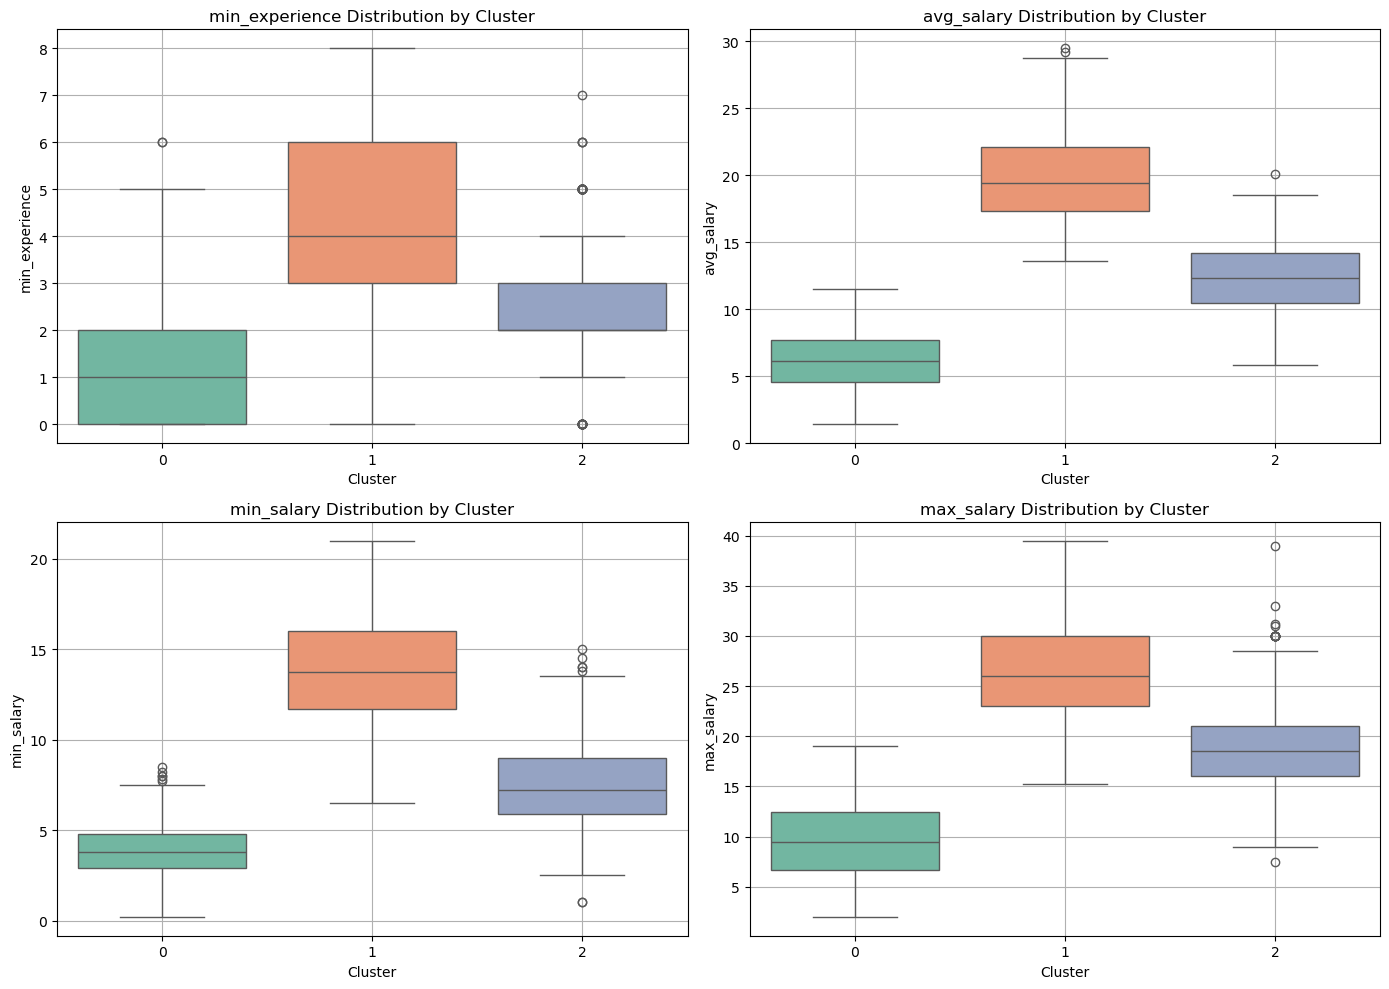

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df_clean[['min_experience', 'avg_salary', 'min_salary', 'max_salary', 'cluster']], 
             hue='cluster', palette='Set1', diag_kind='kde')
plt.suptitle("Pairplot of Features Colored by Cluster", y=1.02)
plt.show()
plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=df_clean, x='cluster', y=col, palette='Set2')
    plt.title(f'{col} Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
cluster_profile = df_clean.groupby('cluster')[numerical_cols].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
print("=== Cluster Profile Summary ===")
print(cluster_profile)
cluster_sizes = df_clean['cluster'].value_counts().sort_index()
print("\n=== Number of members in each cluster ===")
print(cluster_sizes)
avg_salary_by_cluster = df_clean.groupby('cluster')['avg_salary'].mean().sort_values(ascending=False)
print("\n=== Clusters Ranked by Average Salary ===")
print(avg_salary_by_cluster)
def label_clusters(row):
    if row['cluster'] == avg_salary_by_cluster.index[0]:
        return 'High Income EV Buyers'
    elif row['cluster'] == avg_salary_by_cluster.index[-1]:
        return 'Cost-Conscious Segment'
    else:
        return 'Mid Segment'
df_clean['segment_label'] = df_clean.apply(label_clusters, axis=1)

=== Cluster Profile Summary ===
        min_experience                      avg_salary                     \
                  mean median   std min max       mean median   std   min   
cluster                                                                     
0                 1.18    1.0  1.03   0   6       6.07   6.15  2.09   1.4   
1                 4.49    4.0  1.78   0   8      19.83  19.40  3.28  13.6   
2                 2.49    2.0  1.30   0   7      12.43  12.30  2.40   5.8   

              min_salary                         max_salary               \
          max       mean median   std  min   max       mean median   std   
cluster                                                                    
0        11.5       3.84   3.80  1.47  0.2   8.5       9.61    9.5  3.80   
1        29.5      13.82  13.75  3.01  6.5  21.0      26.51   26.0  5.05   
2        20.1       7.49   7.20  2.27  1.0  15.0      18.78   18.5  4.17   

                     
          min   max  
clus

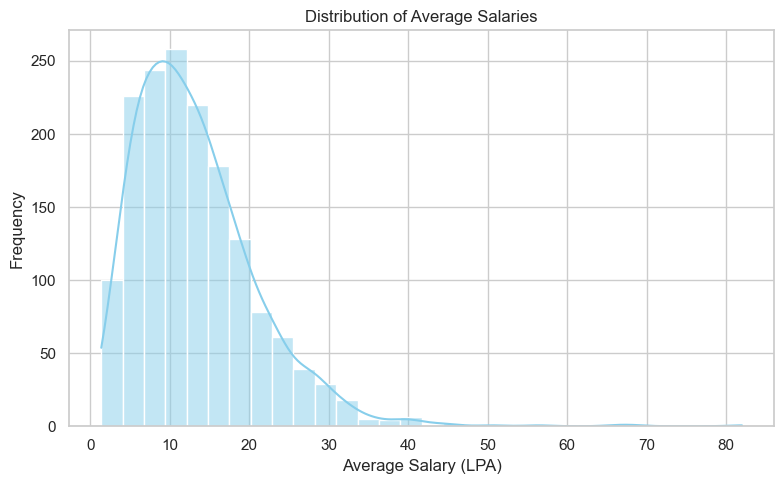

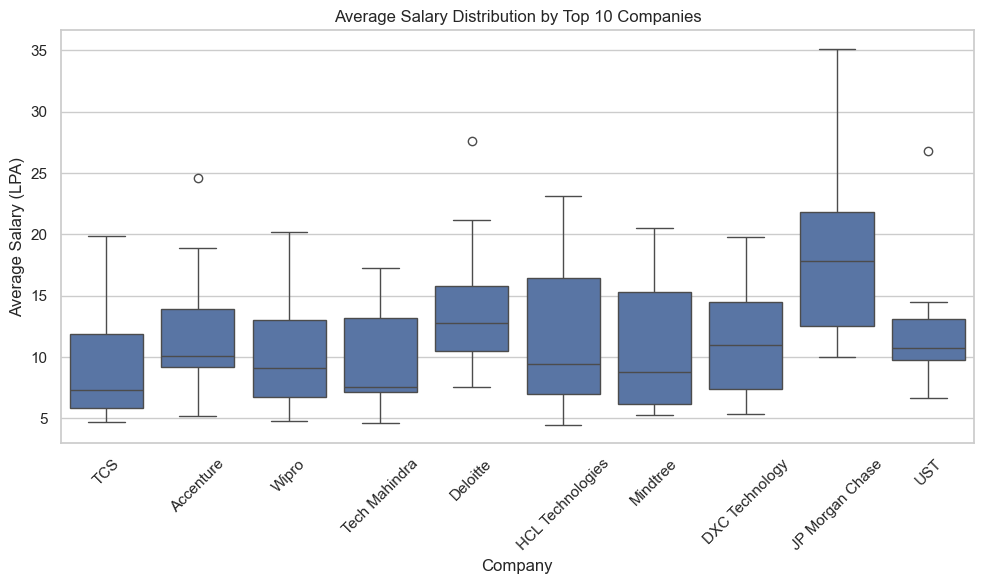

C:\Users\YASHRAJ\AppData\Local\Temp\ipykernel_12400\563016929.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_companies_salary.values, y=top_companies_salary.index, palette='viridis')


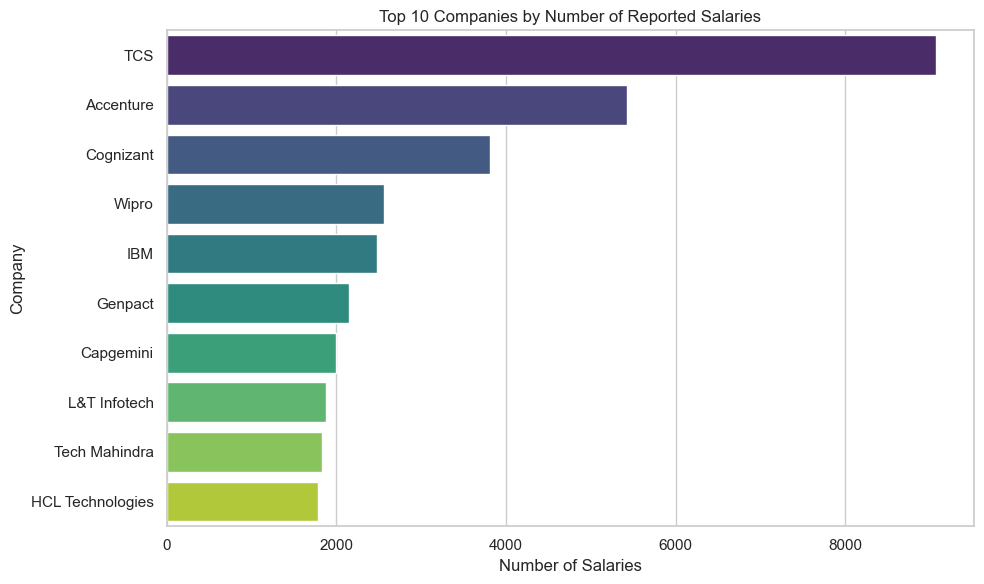

C:\Users\YASHRAJ\AppData\Local\Temp\ipykernel_12400\563016929.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_by_range.values, y=top_10_by_range.index, palette='coolwarm')


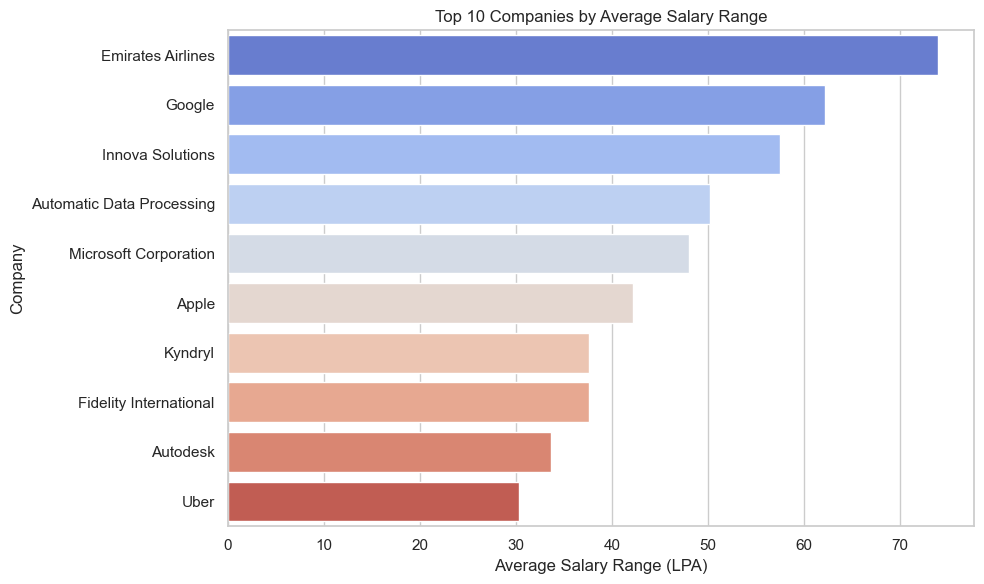

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# df = pd.read_csv('Income.csv')
# salary_cols = ['avg_salary', 'min_salary', 'max_salary']
# for col in salary_cols:
#     df[col] = df[col].str.replace('L', '').astype(float)
# df.drop(columns=['Unnamed: 0'], inplace=True)
sns.set(style='whitegrid')
plt.figure(figsize=(8, 5))
sns.histplot(df['avg_salary'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Average Salaries')
plt.xlabel('Average Salary (LPA)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
top_10_companies = df['company_name'].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['company_name'].isin(top_10_companies)], x='company_name', y='avg_salary')
plt.title('Average Salary Distribution by Top 10 Companies')
plt.xlabel('Company')
plt.ylabel('Average Salary (LPA)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='min_experience', y='avg_salary', hue='company_name', legend=False, alpha=0.7)
plt.title('Experience vs Average Salary')
plt.xlabel('Minimum Experience (Years)')
plt.ylabel('Average Salary (LPA)')
plt.tight_layout()
plt.show()
top_companies_salary = df.groupby('company_name')['num_of_salaries'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_companies_salary.values, y=top_companies_salary.index, palette='viridis')
plt.title('Top 10 Companies by Number of Reported Salaries')
plt.xlabel('Number of Salaries')
plt.ylabel('Company')
plt.tight_layout()
plt.show()
df['salary_range'] = df['max_salary'] - df['min_salary']
top_10_by_range = df.groupby('company_name')['salary_range'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_by_range.values, y=top_10_by_range.index, palette='coolwarm')
plt.title('Top 10 Companies by Average Salary Range')
plt.xlabel('Average Salary Range (LPA)')
plt.ylabel('Company')
plt.tight_layout()
plt.show()

In [6]:
# import pandas as pd

# # Load dataset
# df = pd.read_csv('Income.csv')

# # Clean salary columns
# for col in ['avg_salary', 'min_salary', 'max_salary']:
#     df[col] = df[col].str.replace('L', '').astype(float)

# # Drop unnecessary column
# df.drop(columns=['Unnamed: 0'], inplace=True)

# 1. Shape and Columns
print("Shape of dataset:", df.shape)
print("Columns:", df.columns.tolist())

# 2. Missing Values
print("\nMissing Values:\n", df.isnull().sum())

# 3. Unique Values per Column
print("\nUnique Values:\n", df.nunique())

# 4. Descriptive Statistics
print("\nDescriptive Statistics:\n", df.describe())

# 5. Correlation Matrix
print("\nCorrelation Matrix:\n", df.corr(numeric_only=True))

Shape of dataset: (1602, 9)
Columns: ['Unnamed: 0', 'company_name', 'job_title', 'min_experience', 'avg_salary', 'min_salary', 'max_salary', 'num_of_salaries', 'salary_range']

Missing Values:
 Unnamed: 0         0
company_name       0
job_title          0
min_experience     0
avg_salary         0
min_salary         0
max_salary         0
num_of_salaries    0
salary_range       0
dtype: int64

Unique Values:
 Unnamed: 0         1602
company_name        642
job_title            10
min_experience       18
avg_salary          305
min_salary          197
max_salary          304
num_of_salaries     220
salary_range        404
dtype: int64

Descriptive Statistics:
         Unnamed: 0  min_experience   avg_salary   min_salary   max_salary  \
count  1602.000000     1602.000000  1602.000000  1602.000000  1602.000000   
mean    800.500000        2.799001    13.234894     8.634145    19.143258   
std     462.601881        2.353686     7.840744     5.796976    11.150180   
min       0.000000      

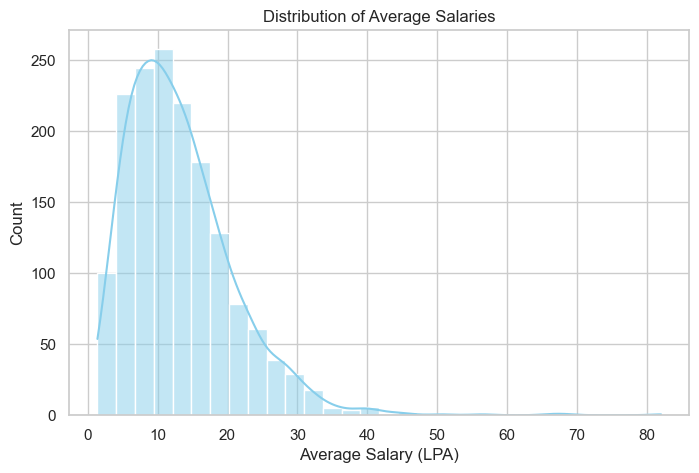

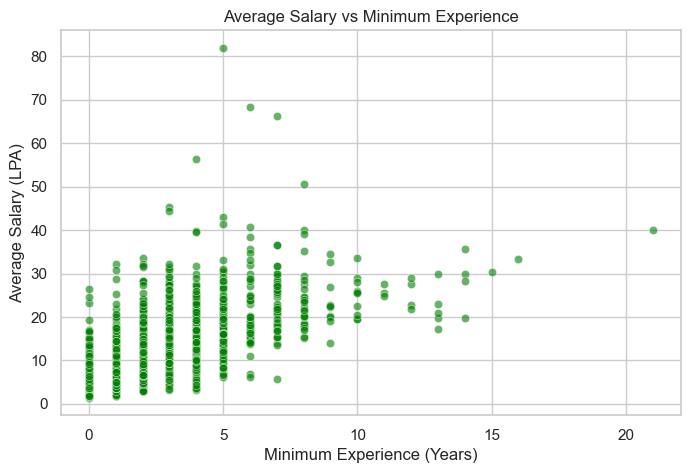

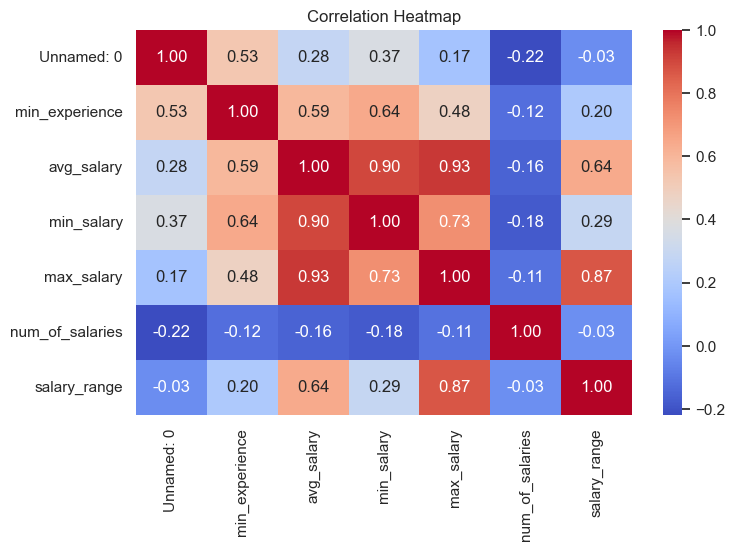

C:\Users\YASHRAJ\AppData\Local\Temp\ipykernel_12400\2454492857.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette='mako')


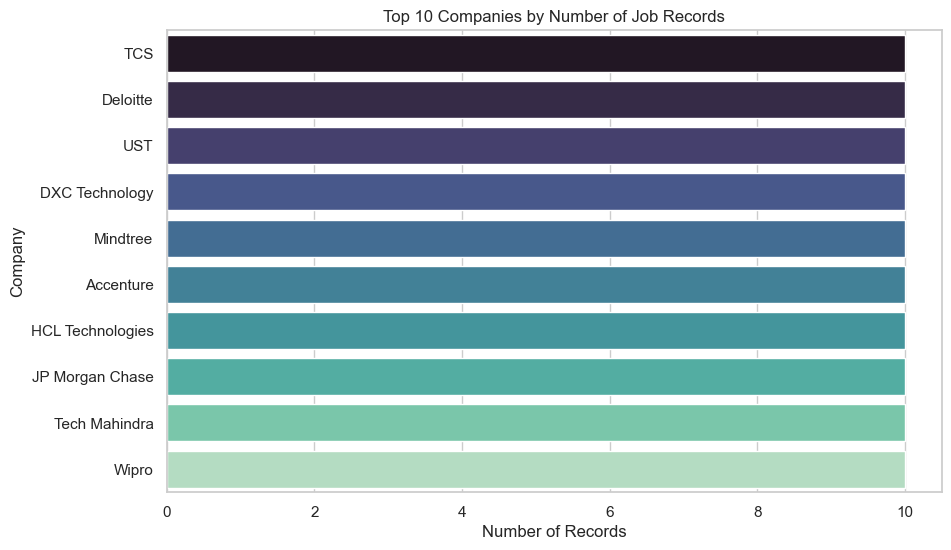

In [7]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load dataset
# df = pd.read_csv("Income.csv")

# # Clean salary columns
# for col in ['avg_salary', 'min_salary', 'max_salary']:
#     df[col] = df[col].str.replace('L', '').astype(float)

# # Drop unnamed index column
# df.drop(columns=['Unnamed: 0'], inplace=True)

# # Create salary range column
df['salary_range'] = df['max_salary'] - df['min_salary']

# Set seaborn style
sns.set(style="whitegrid")

# 1. Histogram of Average Salary
plt.figure(figsize=(8, 5))
sns.histplot(df['avg_salary'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Average Salaries')
plt.xlabel('Average Salary (LPA)')
plt.ylabel('Count')
plt.show()

# 2. Salary vs Experience
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='min_experience', y='avg_salary', alpha=0.6, color='green')
plt.title('Average Salary vs Minimum Experience')
plt.xlabel('Minimum Experience (Years)')
plt.ylabel('Average Salary (LPA)')
plt.show()

# 3. Heatmap of Correlations
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 4. Top Companies by Number of Job Records
top_companies = df['company_name'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_companies.index, x=top_companies.values, palette='mako')
plt.title('Top 10 Companies by Number of Job Records')
plt.xlabel('Number of Records')
plt.ylabel('Company')
plt.show()

# 5. Boxplot of Salary Range in Top Companies
top_10 = df['company_name'].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['company_name'].isin(top_10)], x='company_name', y='salary_range')
plt.title('Salary Range Distribution in Top 10 Companies')
plt.xlabel('Company')
plt.ylabel('Salary Range (LPA)')
plt.xticks(rotation=45)
plt.show()


In [8]:
# Grouping data by company_name
company_salary_stats = df.groupby('company_name').agg({
    'min_salary': 'mean',
    'avg_salary': 'mean',
    'max_salary': 'mean',
    'salary_range': 'mean',
    'num_of_salaries': 'sum',
    'min_experience': 'mean'
}).sort_values(by='avg_salary', ascending=False)

# Renaming columns for clarity
company_salary_stats = company_salary_stats.rename(columns={
    'min_salary': 'Avg Min Salary',
    'avg_salary': 'Avg Salary',
    'max_salary': 'Avg Max Salary',
    'salary_range': 'Avg Salary Range',
    'num_of_salaries': 'Total Salary Reports',
    'min_experience': 'Avg Min Experience'
})

# Display top 10 companies with highest average salaries
print("Top 10 Companies by Average Salary:\n")
print(company_salary_stats.head(10).round(2))


Top 10 Companies by Average Salary:

                           Avg Min Salary  Avg Salary  Avg Max Salary  \
company_name                                                            
Emirates Airlines                   20.00       68.30            94.0   
Hitachi                             25.00       40.00            50.0   
Intuit                              26.00       39.00            47.0   
MSCI                                35.40       38.40            42.0   
Microsoft Corporation               18.67       37.87            66.7   
Automatic Data Processing           20.50       35.45            70.7   
Innova Solutions                    11.00       33.40            68.5   
Fidelity International              18.45       33.25            56.0   
Roche Diagnostics                   23.50       33.10            43.0   
Chegg                               29.90       32.20            35.0   

                           Avg Salary Range  Total Salary Reports  \
company_name     

In [9]:
import pandas as pd

# Step 1: Load dataset
df = pd.read_csv('Income.csv')  # Adjust path if needed

# Step 2: Clean salary columns
for col in ['avg_salary', 'min_salary', 'max_salary']:
    df[col] = df[col].str.replace('L', '').astype(float)

# Step 3: Drop unnamed index column if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Step 4: Create salary range column
df['salary_range'] = df['max_salary'] - df['min_salary']

# Step 5: Group by company and compute statistics
company_salary_stats = df.groupby('company_name').agg({
    'min_salary': 'mean',
    'avg_salary': 'mean',
    'max_salary': 'mean',
    'salary_range': 'mean',
    'num_of_salaries': 'sum',
    'min_experience': 'mean'
}).sort_values(by='avg_salary', ascending=False)

# Step 6: Rename columns for clarity
company_salary_stats.rename(columns={
    'min_salary': 'Avg Min Salary',
    'avg_salary': 'Avg Salary',
    'max_salary': 'Avg Max Salary',
    'salary_range': 'Avg Salary Range',
    'num_of_salaries': 'Total Salary Reports',
    'min_experience': 'Avg Min Experience'
}, inplace=True)

# Step 7: Export to Excel
company_salary_stats.to_excel('company_salary_stats.xlsx')

print("✅ Export complete: 'company_salary_stats.xlsx'")

✅ Export complete: 'company_salary_stats.xlsx'
